## Modelo de Recomendação

### Principais Conceitos:

Existem basicamente dois tipos de modelos de recomendação que podem ser realizados.
1. Content-based filtering: Baseado nas características do item a ser recomendado. 
    * Exemplo: Gênero de um filme, ano de publicação, língua, etc.
2. Collaborative filtering: Baseado em similaridade entre as preferências dos usuários.
    * Diferente do content-based não criamos características, apenas exploramos matematicamente essas similaridades.

#### O que é ALS?

ALS é um modelo de recomendação baseado em calculos de matrizes, portanto, usa apenas calculos matematicos baseados em vetores para encontrar similaridades entre os usuários. 
Existem outros modelos de recomendação, porém esse é extremamente útil por já estar presente dentro do Spark.

#### Tipos 

Para determinarmos o que recomendar, devemos nos basear em como o cliente final está provendo informações sobre a preferência do seu produto. Existem dois tipos:
1. Explicit Ratings: Quando o usuário provê uma avaliação sobre o produto, filme, etc. Essa avaliação pode ser de estrelas, notas de 1 até 5 e por ai vai.
2. Implicit Ratings: Quando o usuário não provê uma avaliação mas tomamos como verdade seu comportamento. O número de vezes que comprou um produto, assistiu a filmes etc.

Para os implicit, ainda podemos apenas usar dados binários onde o usuário pode ou não ter realizado uma ação. Mesmo com dados assim o ALS é capaz de retornar informações valiosas.

#### Fatoração de Matrizes

Na imagem conseguimos entender o que ALS pode fazer. Para relembrar sobre multiplicação entre matrizes: Esse processo acontece para todas as linhas e todas as colunas, ou seja, a segunda linha irá realizar a multiplicação por todos os números da primeira coluna até a última.

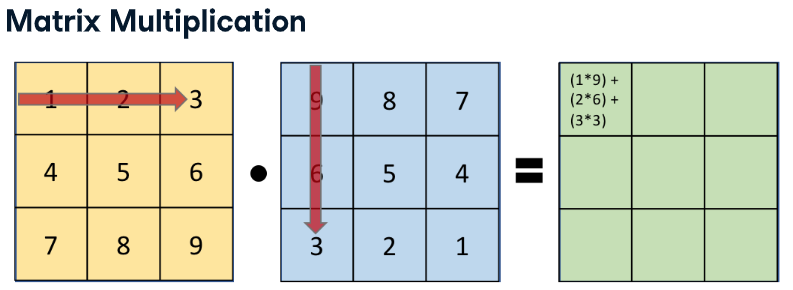

O modelo de ALS faz o contrário da múltiplicação, realiza a fatoração da matriz. Ou seja, estima duas outras matrizes que multiplicadas irão dar **aproximadamente** o valor da matriz original. 

Isso é MUITO poderoso por que embora tenhamos dados vazios em um lugar da matriz, por termos uma informação por linha e coluna é possível **estimar** os dados que estão vazios.

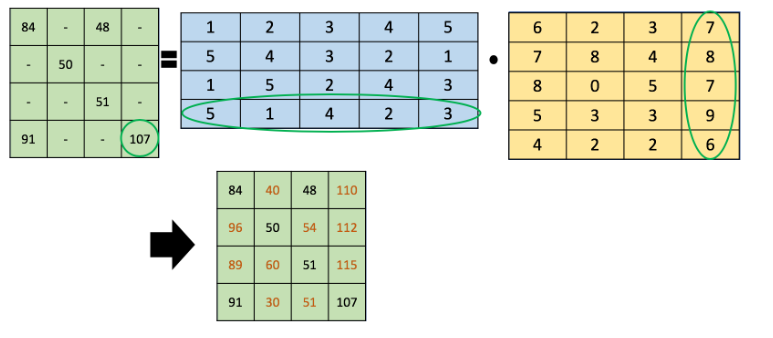

Nós podemos escolher a quantidade de colunas e linhas que essas matrizes terão através dos **hiperparâmetros** do modelo.

A cada iteração o modelo de ALS vai ajustando os valores aproximados das matrizes criadas e reduzindo seu erro. Quanto mais interações mais tempo demorará o prcesso porém menos erros teremos. 

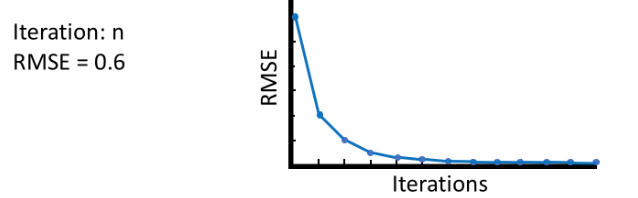

Esse tipo de processo é muito comum possuir uma tabela Sparse, o que significa que existem muitos dados em branco. Isso não é um problema para o método ALS como podemos ver anteriormente. Apenas de tudo, é uma boa prática calcular o quanto % de espaços em brancos temos em nossa matriz. 

#### Prepatação dos Dados

Embora todo o exercício que mostramos na fatoração de matrizes, o método ALS apenas trabalha com dados no formato long. Uma coluna para usuário, outra para o item e uma para o rating.

As colunas todas precisam ser de valor numérico, portanto, precisam ser tratadas quando necessário.

#### Parâmetros e Hyperparâmetros

* Parâmetros:
    1. userCol: Coluna para indicar os usuários
    2. itemCol: Colunas para indicar os itens a serem recomendados
    3. ratingCol: Coluna com o valor do rating, podendo ser binário
* Hyperparâmetro:
    1. rank: Número de colunas e linhas que as matrizes que serão criadas para fatoração terão. Não é um número quanto maior melhor e precisa ser balanceado.
    2. maxIter: Número de vezes que o modelo deve interar entre as matrizes de fatoração. Quanto maior mais tempo irá levar.
    3. regParam: Parâmetro de regularização. É um número adicionado a uma métrica de erro para que o algoritmo não convirja muito rápido aplicando um overfitting.
    4. alpha: Usado apenas quando o ALS será aplicado em dados implicit
* Argumentos:
    1. nonnegative: True or False, podemos determinar se queremos que os resultado obtidos sejam negativos ou não.
    2. coldStartStrategy: Pode acontecer quando separamos o modelo em treino e teste, que todas as interações de um determinado usuário fique no teste. Isso faz com que seja impossível realizar previsões sobre ele. Se passamos o argumento *"drop"* quando isso acontecer não levar em consideração no calculo do RMSE (erro)
    3. implicitPrefs: Aqui é onde dizemos ao nosso modelo se nosso modelo é implicito ou explicito. Defaults to false which means using explicit feedback.

### Dados Utilizados

In [1]:
import pyspark
from pyspark.sql.functions import col, min, avg # to convert columns
import numpy as np

spark = pyspark.sql.SparkSession.builder.getOrCreate()
spark

In [2]:
# Importing dataset

ratings = 'ratings.csv'

ratings = spark.read.csv(ratings, header=True)

ratings.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [3]:
# Calculo de Sparsity

# Count the total number of ratings in the dataset
numerator = ratings.select("rating").count()

# Count the number of distinct userIds and distinct movieIds
num_users = ratings.select("userId").distinct().count()
num_movies = ratings.select("movieId").distinct().count()

# Set the denominator equal to the number of users multiplied by the number of movies
denominator = num_users * num_movies

# Divide the numerator by the denominator
sparsity = (1.0 - (numerator *1.0)/denominator)*100
print("The ratings dataframe is ", "%.2f" % sparsity + "% empty.")

The ratings dataframe is  98.30% empty.


In [29]:
# Min num ratings for movies
print("Movie with the fewest ratings: ")
ratings.groupBy("movieId").count().select(min("count")).show()

# Avg num ratings per movie
print("Avg num ratings per movie: ")
ratings.groupBy("movieId").count().select(avg("count")).show()

# Min num ratings for user
print("User with the fewest ratings: ")
ratings.groupBy("userId").count().select(min("count")).show()

# Avg num ratings per users
print("Avg num ratings per user: ")
ratings.groupBy("userId").count().select(avg("count")).show()

Movie with the fewest ratings: 
+----------+
|min(count)|
+----------+
|         1|
+----------+

Avg num ratings per movie: 
+------------------+
|        avg(count)|
+------------------+
|10.369806663924312|
+------------------+

User with the fewest ratings: 
+----------+
|min(count)|
+----------+
|        20|
+----------+

Avg num ratings per user: 
+------------------+
|        avg(count)|
+------------------+
|165.30491803278687|
+------------------+



In [ ]:
# Use .printSchema() to see the datatypes of the ratings dataset
ratings.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [8]:
ratings = ratings.select(
    ratings.userId.cast("integer"),
    ratings.movieId.cast("integer"), 
    ratings.rating.cast("double")
    )

ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)



### Explicit Recommendation 

#### Without tunning

In [9]:
# Import the required functions
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [10]:
# Split Data
(training_data, test_data) = ratings.randomSplit([0.8, 0.2])

# Build ALS Model
als =  ALS(
    userCol='userId',
    itemCol='movieId',
    ratingCol='rating',
    rank=25,
    maxIter=5,
    regParam=.05,
    nonnegative=True,
    coldStartStrategy='drop',
    implicitPrefs=False
)

In [11]:
# Fit model to training data
model = als.fit(training_data)

# Generate predictions on test_data
predictions = model.transform(test_data)

In [26]:
# Evaluate predictions
evaluator = RegressionEvaluator(
    metricName='rmse',
    labelCol='rating',
    predictionCol='prediction'
)

# RMSE
rmse =  evaluator.evaluate(predictions)

print(rmse)

0.9222151290572485


An RMSE of 0.9327 means that on average the model predicts 0.9327 above or below values of the original ratings matrix.

In [23]:
ALS_recommendations = model.recommendForAllUsers(3)

O código acima escolhe as 3 melhores previsões por usuário.
Após isso é necessário realizar um tratamento nos dados para que possam ser consumidos de forma tabular.

Ao fazermos dessa forma serão mostrados filmes que nunca foram vistos pelo usuário.

In [25]:
ALS_recommendations.registerTempTable('ALS_recs_temp')

clean_recs = spark.sql("""
                       SELECT 
                        userId
                       , movieIds_and_ratings.movieId AS movieId
                       , movieIds_and_ratings.rating AS prediction
                       FROM ALS_recs_temp
                       LATERAL VIEW explode(recommendations) exploded_table AS movieIds_and_ratings
                       """)

c:\Users\Plugify\anaconda3\lib\site-packages\pyspark\sql\dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [17]:
clean_recs.show()

+------+-------+----------+
|userId|movieId|prediction|
+------+-------+----------+
|     1|    922| 6.0046644|
|     1|   3451|  5.831585|
|     1|   3435|  5.812373|
|     2|    945|  5.369495|
|     2|  98279|   5.15073|
|     2|   5480|  5.108748|
|     3|   2851| 5.1173525|
|     3|   5919|  5.102237|
|     3|   7991|  5.095596|
|     4|  70946| 5.4004817|
|     4|   3851| 5.1572847|
|     4|   1733| 5.1572847|
|     5|   5690| 5.3205504|
|     5|   1235| 5.1974883|
|     5|   3200|  5.191409|
|     6|   2990| 5.2590795|
|     6|   6380| 5.1952157|
|     6| 111617| 5.0426626|
|     7|   1207|  5.177237|
|     7|   1262|  5.029667|
+------+-------+----------+
only showing top 20 rows



#### With tunning

In [12]:
# Create test and train set
(train, test) = ratings.randomSplit([0.8, 0.2], seed = 1234)

# Create ALS model
als_tunning = ALS(
    userCol="userId", 
    itemCol="movieId", 
    ratingCol="rating", 
    nonnegative = True, 
    implicitPrefs = False
    )

# Confirm that a model called "als" was created
type(als_tunning)

pyspark.ml.recommendation.ALS

In [13]:
# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als_tunning.rank, [10, 15, 20, 25]) \
            .addGrid(als_tunning.maxIter, [1, 5, 10]) \
            .addGrid(als_tunning.regParam, [.01, .05, .1]) \
            .build()
           
# Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
print ("Num models to be tested: ", len(param_grid))

Num models to be tested:  36


In [14]:
# Build cross validation using CrossValidator
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

# numFolds: the number of training set folds we want each model to be tested on

# Confirm cv was built
print(cv)

CrossValidator_55f418301ae4


In [15]:
#Fit cross validator to the 'train' dataset
model = cv.fit(train)

#Extract best model from the cv model above
best_model = model.bestModel

In [21]:
# Print best_model
print("**Best Model**")
print(type(best_model))

<class 'pyspark.ml.recommendation.ALSModel'>


25

In [27]:
# Print "Rank"
print("  Rank:", best_model.rank)

# Print "MaxIter"
print("  MaxIter:", best_model._java_obj.parent().getMaxIter())

# Print "RegParam"
print("  RegParam:", best_model._java_obj.parent().getRegParam())

  Rank: 25
  MaxIter: 5
  RegParam: 0.05


Exemplo de Leitura do RMSE: 0.633
* RMSE: An RMSE of 0.633 means that on average the model predicts 0.633 above or below values of the original ratings matrix.

In [28]:
# Evaluating the test

test_predictions = best_model.transform(test)

RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

0.9264827701655817


### Implicit Recommendation

Para métodos Implicitos precisamos ter uma dataframe com a combinação de todos os clientes com todos os 'produtos' ou 'itens' a serem avaliados. Obviamente que nesse formato diversos itens não terão sido 'vendidos' para todos os clientes. Para esses casos é importante que preenchamos com 0 quando não for encontrado.
Praticamente, é como usar um crossjoin com fillna(0).

Um ponto muito impactante é como vamos medir o sucesso do treino e do teste, ou seja, nossa forma de avaliação.

Anteriormente estavamos usando um RMSE, o que faz sentido como métrica de desvio pois mostra o quanto estamos desviando no valor original. 

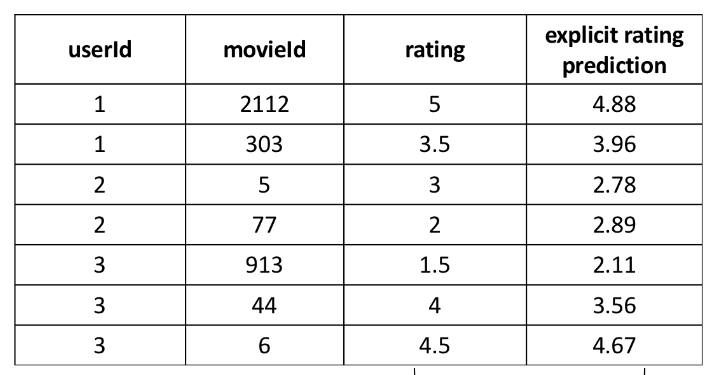
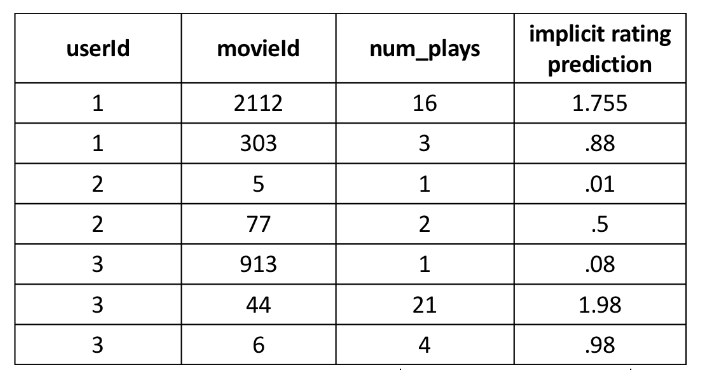

Porém usando dados de comportamento esse número não se torna tão sólido. Por isso vamos usar o ROEM.

* ROEM: Ele checa se os itens com alto número de interação também tem um alto número na previsão.

O ROEM não pode estar perto de 0.5, ou não será muito melhor do que uma escolha aleatória. Quanto mais perto de 0, melhor!

*Para fins didáticos, vamos usar o mesmo dataset utilizado anteriormente como se fosse um dado implicito.*

In [28]:
# ROEM formula
def ROEM(predictions, userCol, itemCol, ratingCol):
    #Creates table that can be queried
    predictions.createOrReplaceTempView("predictions")

    #Sum of total number of plays of all songs
    denominator = predictions.groupBy().sum(ratingCol).collect()[0][0]

    #Calculating rankings of songs predictions by user
    spark.sql("SELECT " + userCol + " , " + ratingCol + " , PERCENT_RANK() OVER (PARTITION BY " + userCol + " ORDER BY prediction DESC) AS rank FROM predictions").createOrReplaceTempView("rankings")

    #Multiplies the rank of each song by the number of plays and adds the products together
    numerator = spark.sql('SELECT SUM(' + ratingCol + ' * rank) FROM rankings').collect()[0][0]

    performance = numerator/denominator

    return performance

In [32]:
ROEM = ROEM(predictions, userCol='userId', itemCol='movieId', ratingCol='rating')

print(ROEM)

0.4688993882985705


### Considerações Finais

A beleza de um modelo de classificação **NÃO ESTÁ NA PREVISÃO** e sim no **PÓS PROCESSAMENTO**. 

O pós processamento é o momento em que podemos pegar os resultados do modelo e incrementar com dados úteis, por exemplo quando falamos em um produto é verificar se todos possuem estoque ou até mesmo se o cliente já comprou esse produto.

Caso já tenha comprado é possível penalizar a nota dada pelo modelo e encontrar outro melhor produto a ser recomendado.

Vale destacar que o ALS beneficia produtos best sellers, e isso deve ser levado em conta quando ofertar determinados produtos.